In [1]:
import pickle
export=pickle.load(open('/data/db/import/save/paralogs-export-korum.pkl', 'rb'))

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib import pyplot
pyplot.rc('axes', labelsize=15)    # fontsize of the x and y labels


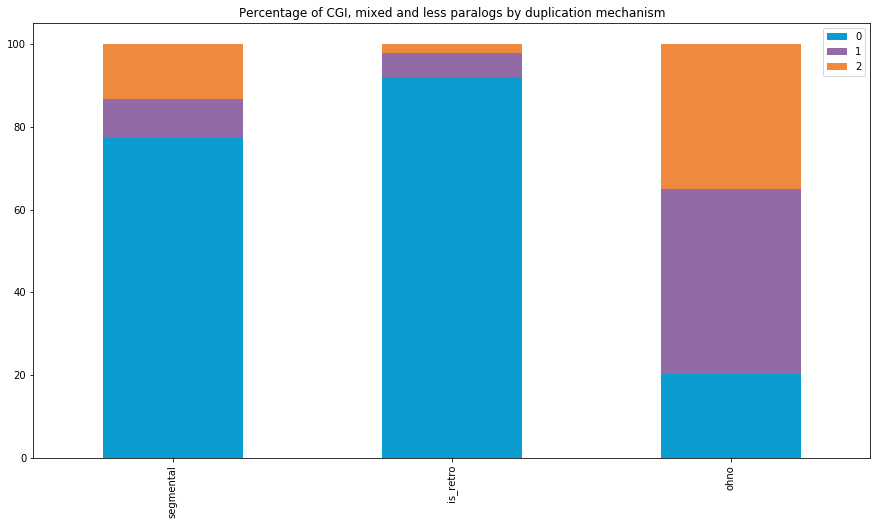

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import read_csv

#plt.stackplot(['WGD'], [export[(export['CpG-ness'] == 0)&(export['ohno']==True)].sum()], [export[(export['CpG-ness'] == 1)&(export['ohno']==True)].sum()], [export[(export['CpG-ness'] == 2)&(export['ohno']==True)].sum()],
#              labels=['CpG-less', 'mixed', 'CpG-full'], colors=['#0b9dcf','#926aa5', '#ef893d'])
fig, ax = plt.subplots(figsize=(15,8))
ohno=set((orow['Ohno1'], orow['Ohno2']) for orow in read_csv(r'/data/db/import/ohno/7_FilterOhnologs/hsapiens/hsapiens_Criteria-[C]-Pairs.txt', delimiter='\t').iloc)
export=export.assign(ohno=export[['g1', 'g2']].apply(lambda x: (x[0], x[1]), axis=1).isin(ohno)|export[['g1', 'g2']].apply(lambda x: (x[1], x[0]), axis=1).isin(ohno))
recent = export[export['Branch point'].isin(["Primates", "Haplorrhini", "Simiiformes", "Catarrhini","Hominoidea", "Hominidae", "Homininae", "Homo sapiens"])]
recent = recent.assign(is_retro = recent['retro'] !=  0)

mechsum=recent[['CpG-ness', 'segmental', 'is_retro']].groupby('CpG-ness').sum().join(export[['ohno', 'CpG-ness']].groupby('CpG-ness').sum(), on='CpG-ness')
(mechsum/mechsum.sum()*100).T.plot(ax=ax,
    kind='bar', stacked=True, color=['#0b9dcf','#926aa5', '#ef893d'])

plt.legend()
plt.title('Percentage of CGI, mixed and less paralogs by duplication mechanism')
plt.savefig('human-dup-mechanism-fraction-of-cgi-paralogs.pdf', dpi=600)
plt.show()

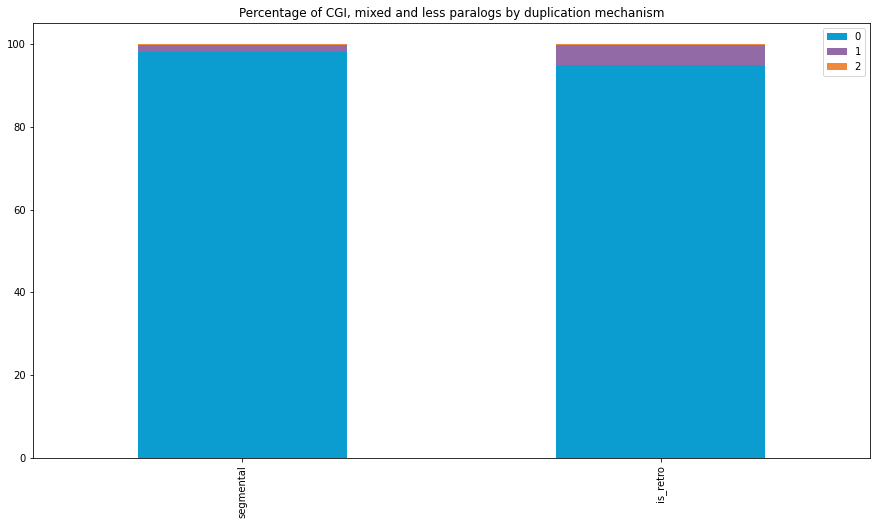

In [101]:
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import read_csv
mexport = read_csv('mouse-paralogs-exocon.csv')[['CpG-ness', 'Branch point', 'g1', 'g2', 'retro', 'segmental']]

#plt.stackplot(['WGD'], [export[(export['CpG-ness'] == 0)&(export['ohno']==True)].sum()], [export[(export['CpG-ness'] == 1)&(export['ohno']==True)].sum()], [export[(export['CpG-ness'] == 2)&(export['ohno']==True)].sum()],
#              labels=['CpG-less', 'mixed', 'CpG-full'], colors=['#0b9dcf','#926aa5', '#ef893d'])
fig, ax = plt.subplots(figsize=(15,8))
mrecent = mexport[mexport['Branch point'].isin(["Glires", "Rodentia", "Myomorpha", "Muroidea", "Muridae", "Murinae", "Mus", "Mus musculus strain reference (CL57BL6)"])]
mrecent = mrecent.assign(is_retro = mrecent['retro'] !=  0)
mmechsum=mrecent[['CpG-ness', 'segmental', 'is_retro']].groupby('CpG-ness').sum()
(mmechsum/mmechsum.sum()*100).T.plot(ax=ax,
    kind='bar', stacked=True, color=['#0b9dcf','#926aa5', '#ef893d'])

plt.legend()
plt.title('Percentage of CGI, mixed and less paralogs by duplication mechanism')
plt.savefig('mouse-dup-mechanism-fraction-of-cgi-paralogs.pdf', dpi=600)
plt.show()

In [115]:
from scipy.stats import chisquare
#Branch point is an arbitrary column that has no NaNs
print('Segmental pvalue %f\nRetro pvalue %f\nOhno pvalue %f'%(
    chisquare(mechsum['segmental'], recent.groupby('CpG-ness').count()['Branch point'])[1],
    chisquare(mechsum['is_retro'], recent.groupby('CpG-ness').count()['Branch point'])[1],
    chisquare(mechsum['ohno'], export.groupby('CpG-ness').count()['Branch point'])[1]))


Segmental pvalue 0.000000
Retro pvalue 0.000000
Ohno pvalue 0.000000


In [103]:
from scipy.stats import chisquare
#Branch point is an arbitrary column that has no NaNs
print('Segmental pvalue %f\nRetro pvalue %f'%(
    chisquare(mmechsum['segmental'], mrecent.groupby('CpG-ness').count()['Branch point'])[1],
    chisquare(mmechsum['is_retro'], mrecent.groupby('CpG-ness').count()['Branch point'])[1]))


Segmental pvalue 0.000000
Retro pvalue 0.000000


In [27]:
from pandas import read_csv, DataFrame
import gffutils
from overlap_calc import *
import numpy as np
from itertools import *
cpgs_dr_testes = load_cpg_bed('/home/evgeny/tau/gen_cpg/dr_testes_nmi.bed')
dr_db = gffutils.FeatureDB('dr.db')
dr_canons = list(canonical_transcripts(dr_db, r'./Danio_rerio.GRCz11.dna_sm.primary_assembly.fa'))
dr_overlap_testes = cpg_overlap(dr_canons, cpgs_dr_testes, pre_tss=300, post_tss=100)
orthos = read_csv('/data/db/import/dr_orthologs.txt')
dr_ca = set((o[0], o[1]) for o in orthos[['Gene stable ID', 'Goldfish gene stable ID']].dropna().iloc)
dr_cc = set((o[0], o[1]) for o in orthos[['Gene stable ID', 'Common carp gene stable ID']].dropna().iloc)
dr_ca_o=[x for x in ((x[0], list(x[1] for x in x[1])) for x in groupby(sorted(dr_ca, key=lambda x:x[0]), key=lambda x: x[0]))]
dr_cc_o=[x for x in ((x[0], list(x[1] for x in x[1])) for x in groupby(sorted(dr_cc, key=lambda x:x[0]), key=lambda x: x[0]))]
ca_dr_o=[x for x in ((x[0], list(x[1] for x in x[1])) for x in groupby(sorted(dr_ca, key=lambda x:x[1]), key=lambda x: x[1]))]
cc_dr_o=[x for x in ((x[0], list(x[1] for x in x[1])) for x in groupby(sorted(dr_cc, key=lambda x:x[1]), key=lambda x: x[1]))]
[list(x[1]) for x in groupby(dr_cc, key=lambda x: x[0]) ]
[list(x[1]) for x in groupby(dr_cc, key=lambda x: x[0]) if len(list(x[1]))==2]

p_ca = { (p[0], p[1]) : p[2] for p in read_csv('/data/db/import/goldfish_paralog.csv')[['Gene stable ID', 'Goldfish paralogue gene stable ID', 'Paralogue last common ancestor with Goldfish']].dropna().iloc }
p_cc = { (p[0], p[1]) : p[2] for p in read_csv('/data/db/import/carp_paralog.csv')[['Gene stable ID', 'Common carp paralogue gene stable ID', 'Paralogue last common ancestor with Common carp']].dropna().iloc }
para_ca = list(chain(*[[(x[0], o) for o in combinations(x[1], 2) if o in p_ca and p_ca[o] == 'Cyprininae' or o[::-1] in p_ca and p_ca[o[::-1]] == 'Cyprinine'] for x in dr_ca_o]))
para_cc = list(chain(*[[(x[0], o) for o in combinations(x[1], 2) if o in p_cc and p_cc[o] == 'Cyprininae' or o[::-1] in p_cc and p_cc[o[::-1]] == 'Cyprinine'] for x in dr_cc_o]))
para_ca_full = list(chain(*[[(x[0], o) for o in combinations(x[1], 2)] for x in dr_ca_o]))
para_cc_full = list(chain(*[[(x[0], o) for o in combinations(x[1], 2)] for x in dr_cc_o]))



dr_cc_o_d = dict(dr_cc_o)
dr_ca_o_d = dict(dr_ca_o)


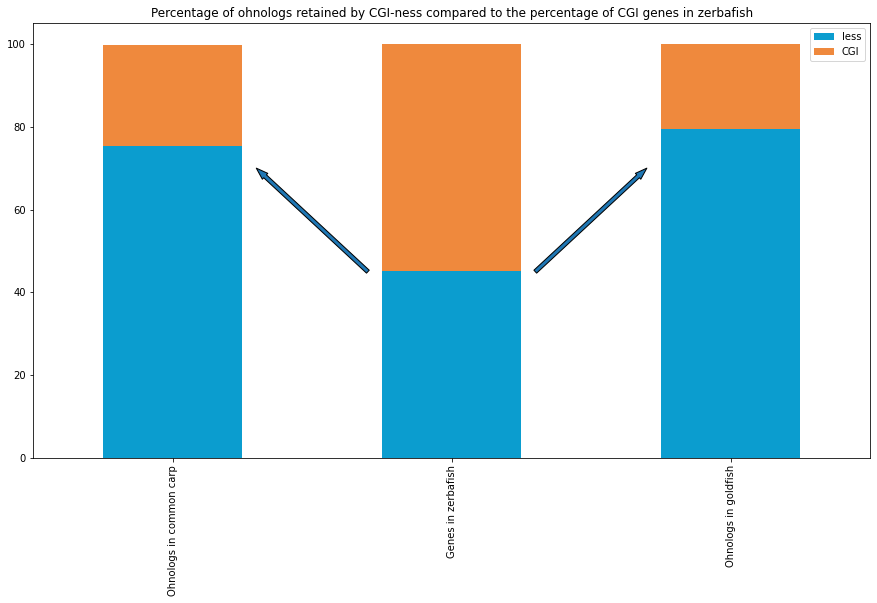

In [57]:
fig, ax = plt.subplots(figsize=(15,8))
fishohno = DataFrame.from_records(columns=['Ohnologs in common carp', 'Genes in zerbafish', 'Ohnologs in goldfish'],
                       data=[[len([x for x in para_cc if 'gene:'+x[0] in dr_overlap_testes and  dr_overlap_testes['gene:'+x[0]] <= 0.5])/len(para_cc)*100, len([x for x in dr_overlap_testes.keys() if dr_overlap_testes[x] <= 0.5])/len(dr_overlap_testes)*100, len([x for x in para_ca if 'gene:'+x[0] in dr_overlap_testes and  dr_overlap_testes['gene:'+x[0]] <= 0.5])/sum(1 for x in para_ca if 'gene:'+x[0] in dr_overlap_testes)*100],
                             [len([x for x in para_cc if 'gene:'+x[0] in dr_overlap_testes and  dr_overlap_testes['gene:'+x[0]] > 0.5])/len(para_cc)*100, len([x for x in dr_overlap_testes.keys() if dr_overlap_testes[x] > 0.5])/len(dr_overlap_testes)*100, len([x for x in para_ca if 'gene:'+x[0] in dr_overlap_testes and  dr_overlap_testes['gene:'+x[0]] > 0.5])/sum(1 for x in para_ca if 'gene:'+x[0] in dr_overlap_testes)*100]]) 
#plt.stackplot(['Ohnologs in common carp', 'Genes in zerbafish', 'Ohnologs in goldfish'],
#              [len([x for x in para_cc_full if 'gene:'+x[0] in dr_overlap_testes and  dr_overlap_testes['gene:'+x[0]] <= 0.5])/len(para_cc_full)*100, len([x for x in dr_overlap_testes.keys() if dr_overlap_testes[x] <= 0.5])/len(dr_overlap_testes)*100, len([x for x in para_ca_full if 'gene:'+x[0] in dr_overlap_testes and  dr_overlap_testes['gene:'+x[0]] <= 0.5])/sum(1 for x in para_ca_full if 'gene:'+x[0] in dr_overlap_testes)*100],
#              [len([x for x in para_cc_full if 'gene:'+x[0] in dr_overlap_testes and  dr_overlap_testes['gene:'+x[0]] > 0.5])/len(para_cc_full)*100, len([x for x in dr_overlap_testes.keys() if dr_overlap_testes[x] > 0.5])/len(dr_overlap_testes)*100, len([x for x in para_ca_full if 'gene:'+x[0] in dr_overlap_testes and  dr_overlap_testes['gene:'+x[0]] > 0.5])/sum(1 for x in para_ca_full if 'gene:'+x[0] in dr_overlap_testes)*100],              
#              labels=['CpG-less', 'CpG-full'], colors=['#0b9dcf', '#ef893d'])
fishohno.rename({ 0 : 'less', 1 : 'CGI'}).T.plot(ax=ax,
    kind='bar', stacked=True, color=['#0b9dcf','#ef893d'])
ax.annotate("", xytext=(0.7, 45.0), xy=(0.3, 70.0), arrowprops=dict(width=4, headwidth=8))
ax.annotate("", xytext=(1.3, 45.0), xy=(1.7, 70.0), arrowprops=dict(width=4, headwidth=8))
plt.legend()
plt.title('Percentage of ohnologs retained by CGI-ness compared to the percentage of CGI genes in zerbafish')
plt.savefig('fishes-ohnolog-paralog-retention-by-cgi.pdf', dpi=600)
plt.show()
#fishohno

In [105]:
from scipy.stats import fisher_exact
odds_ratio1, pvalue1=fisher_exact([[len([x for x in dr_overlap_testes.keys() if dr_overlap_testes[x] <= 0.5]), len([x for x in dr_overlap_testes.keys() if dr_overlap_testes[x] > 0.5])],
              [len([x for x in para_cc_full if 'gene:'+x[0] in dr_overlap_testes and  dr_overlap_testes['gene:'+x[0]] <= 0.5]), len([x for x in para_cc_full if 'gene:'+x[0] in dr_overlap_testes and  dr_overlap_testes['gene:'+x[0]] > 0.5])]])
odds_ratio2, pvalue2=fisher_exact([[len([x for x in dr_overlap_testes.keys() if dr_overlap_testes[x] <= 0.5]), len([x for x in dr_overlap_testes.keys() if dr_overlap_testes[x] > 0.5])],
              [len([x for x in para_ca_full if 'gene:'+x[0] in dr_overlap_testes and  dr_overlap_testes['gene:'+x[0]] <= 0.5]), len([x for x in para_ca_full if 'gene:'+x[0] in dr_overlap_testes and  dr_overlap_testes['gene:'+x[0]] > 0.5])]])
print('pvalue common carp %f\npvalue goldfish %f'%(pvalue1, pvalue2))

pvalue common carp 0.000000
pvalue goldfish 0.000000


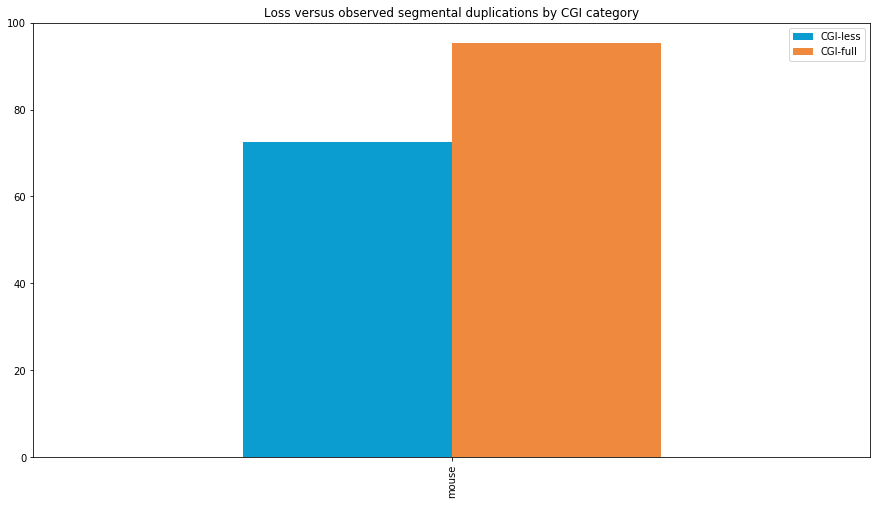

,CGI-less,CGI-full
mouse,72.54509,95.378151


In [6]:
from pandas import DataFrame
import matplotlib.pyplot as plt
segsols=pickle.load(open('/data/db/import/save/human-mouse-segsols.pkl', 'rb'))
def split_overlaps(gene_overlap):
    return [g for g in gene_overlap.keys() if gene_overlap[g] < 0.5], [g for g in gene_overlap.keys() if gene_overlap[g] > 0.5]

overlap = pickle.load(open('/home/gencpg/gen_cpg/ucsc_overlaps_300.pkl', 'rb'))
cpg_less, cpg_full = [set(s) for s in split_overlaps(overlap)]

mouseoutgroup = DataFrame.from_records(columns=['CGI-less', 'CGI-full'],
                       data=[[
                           100*sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+(y[1] or y[2])) in cpg_less for y in x[1]) for x in segsols)/(sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+(y[1] or y[2])) in cpg_less for y in x[1]) for x in segsols)+sum(sum((('gene:'+y[1]) in cpg_less) + (('gene:'+y[2]) in cpg_less) if y[0] != None and y[1] != None and y[2] != None else 0 for y in x[1]) for x in segsols)),
                           100*sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+(y[1] or y[2])) in cpg_full for y in x[1]) for x in segsols)/(sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+(y[1] or y[2])) in cpg_full for y in x[1]) for x in segsols)+sum(sum((('gene:'+y[1]) in cpg_full) + (('gene:'+y[2]) in cpg_full) if y[0] != None and y[1] != None and y[2] != None else 0 for y in x[1]) for x in segsols))
                       ]]).rename({ 0 : 'mouse'})
                 
fig, ax = plt.subplots(figsize=(15,8))
ax.set_ylim([0, 100])
mouseoutgroup.plot(ax=ax, kind='bar', stacked=False,    color=['#0b9dcf','#ef893d'])


plt.title('Loss versus observed segmental duplications by CGI category')
plt.savefig('human-mouse-segmental-paralog-retention-by-cgi.pdf', dpi=600)
plt.show()
mouseoutgroup
#fishohno.rename({ 0 : 'less', 1 : 'CGI'}).T

/home/gencpg/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Expression control leaves 64 pairs


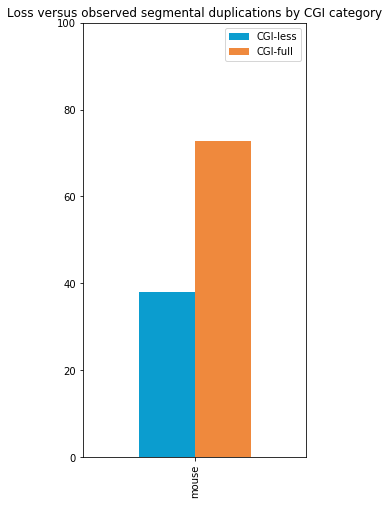

,CGI-less,CGI-full
mouse,38.095238,72.727273


In [54]:
from itertools import chain
from pandas import DataFrame, concat
retained=set(chain(*chain(*[[(x[1], x[2]) for x in s[1] if x[0] != None and x[1] != None and x[2] != None] for s in segsols])))
lost=set(chain(*[[x[1] if x[1] != None else x[2] for x in s[1] if x[0] != None and ((x[1] == None) + (x[2] == None)) == 1 ] for s in segsols]))

from pandas import DataFrame, concat
retframe=concat([DataFrame.from_records([(x, 1) for x in retained], columns=['gene', 'retained']),
           DataFrame.from_records([(x, 0) for x in lost], columns=['gene', 'retained'])])
retframe=retframe.join(
pickle.load(open('/data/db/import/save/paralogs-genexpr.pkl', 'rb')).drop(columns=['cpgness', 'cpgfull']).max(axis=1).rename('maxexpr')
, on='gene').assign(exprlog=lambda x: np.log(x['maxexpr']))
from row_matchers import one_to_one_matches
retainedf, lostf = one_to_one_matches(retframe[(abs(retframe['exprlog']) != np.inf) & retframe['exprlog'].notna() & retframe['retained'] == 1], retframe[(abs(retframe['exprlog']) != np.inf) & retframe['exprlog'].notna() & retframe['retained'] == 0], 'exprlog', 1.8)
print('Expression control leaves %d pairs'%len(lostf))


mouseoutgroup = DataFrame.from_records(columns=['CGI-less', 'CGI-full'],
                       data=[[
                           100*sum(1 for x in cpg_less if x.split(':')[1] in set(lostf['gene']))/(sum(1 for x in cpg_less if x.split(':')[1] in set(lostf['gene']))+sum(1 for x in cpg_less if x.split(':')[1] in set(retainedf['gene']))),
                           100*sum(1 for x in cpg_full if x.split(':')[1] in set(lostf['gene']))/(sum(1 for x in cpg_full if x.split(':')[1] in set(lostf['gene']))+sum(1 for x in cpg_full if x.split(':')[1] in set(retainedf['gene'])))
                       ]]).rename({ 0 : 'mouse'})
                 
fig, ax = plt.subplots(figsize=(4,8))
ax.set_ylim([0, 100])
mouseoutgroup.plot(ax=ax, kind='bar', stacked=False,    color=['#0b9dcf','#ef893d'])


plt.title('Loss versus observed segmental duplications by CGI category')
plt.savefig('human-mouse-segmental-paralog-retention-by-cgi-expr-ctrl.pdf', dpi=600)
plt.show()
mouseoutgroup


In [ ]:

from scipy.stats import fisher_exact

fisher_exact([[(sum(1 for x in cpg_less if x.split(':')[1] in set(lostf['gene']))+sum(1 for x in cpg_less if x.split(':')[1] in set(retainedf['gene']))),
               (sum(1 for x in cpg_full if x.split(':')[1] in set(lostf['gene']))+sum(1 for x in cpg_full if x.split(':')[1] in set(retainedf['gene'])))],
              [sum(1 for x in cpg_less if x.split(':')[1] in set(lostf['gene'])),
               sum(1 for x in cpg_full if x.split(':')[1] in set(lostf['gene']))]])


(1.9090909090909092, 0.04259249207346742)

In [51]:
retframe[(abs(retframe['exprlog']) != np.inf) & retframe['exprlog'].notna() & retframe['retained'] == 1]

,gene,retained,maxexpr,exprlog
0,ENSG00000214042,1,0.035126,-3.348819
1,ENSG00000239998,1,86.019400,4.454573
3,ENSG00000182613,1,0.107431,-2.230906
4,ENSG00000198502,1,400.145000,5.991827
6,ENSG00000171478,1,0.061445,-2.789616
...,...,...,...,...
112,ENSG00000242221,1,0.100388,-2.298713
115,ENSG00000178586,1,6.926510,1.935356
116,ENSG00000284373,1,0.246667,-1.399716
118,ENSG00000197919,1,0.217626,-1.524977


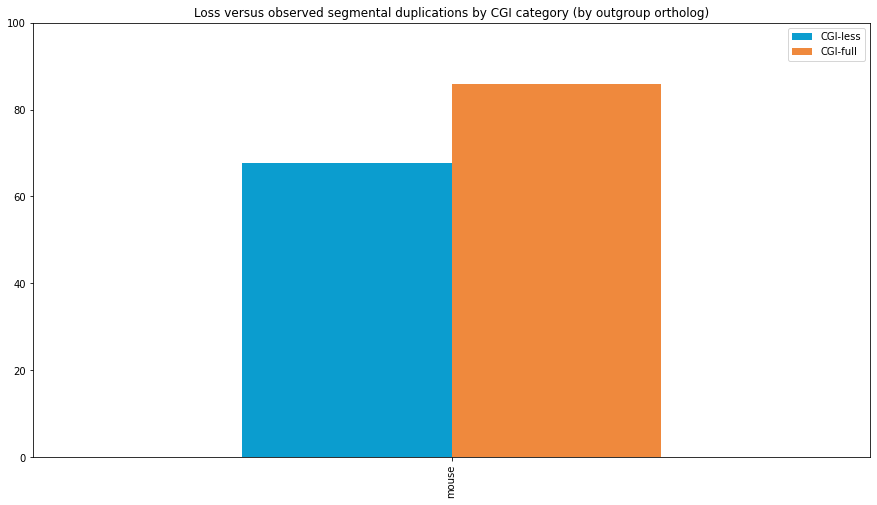

,CGI-less,CGI-full
mouse,67.791411,85.844749


In [92]:
mm_overlap = pickle.load(open('/home/gencpg/gen_cpg/mouse_overlaps_ensembl_300.pkl', 'rb'))
mm_cpg_less, mm_cpg_full = [set(s) for s in split_overlaps(mm_overlap)]

mouseoutgroup = DataFrame.from_records(columns=['CGI-less', 'CGI-full'],
                       data=[[
                           100*sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+y[0] in mm_cpg_less) for y in x[1]) for x in segsols)/(sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+y[0]) in mm_cpg_less for y in x[1]) for x in segsols)+sum(sum((('gene:'+y[0]) in mm_cpg_less) + (('gene:'+y[0]) in mm_cpg_less) if y[0] != None and y[1] != None and y[2] != None else 0 for y in x[1]) for x in segsols)),
                           100*sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+y[0] in mm_cpg_full) for y in x[1]) for x in segsols)/(sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+y[0]) in mm_cpg_full for y in x[1]) for x in segsols)+sum(sum((('gene:'+y[0]) in mm_cpg_full) + (('gene:'+y[0]) in mm_cpg_full) if y[0] != None and y[1] != None and y[2] != None else 0 for y in x[1]) for x in segsols))
                       ]]).rename({ 0 : 'mouse'})
                 
fig, ax = plt.subplots(figsize=(15,8))
ax.set_ylim([0, 100])
mouseoutgroup.plot(ax=ax, kind='bar', stacked=False,    color=['#0b9dcf','#ef893d'])


plt.title('Loss versus observed segmental duplications by CGI category (by outgroup ortholog)')
plt.savefig('human-mouse-segmental-paralog-retention-by-cgi-by-outgroup.pdf', dpi=600)
plt.show()
mouseoutgroup
#fishohno.rename({ 0 : 'less', 1 : 'CGI'}).T

In [106]:
from scipy.stats import fisher_exact

fisher_exact([[(sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+(y[1] or y[2])) in cpg_less for y in x[1]) for x in segsols)+sum(sum((('gene:'+y[1]) in cpg_less) + (('gene:'+y[2]) in cpg_less) if y[0] != None and y[1] != None and y[2] != None else 0 for y in x[1]) for x in segsols)),
               (sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+(y[1] or y[2])) in cpg_full for y in x[1]) for x in segsols)+sum(sum((('gene:'+y[1]) in cpg_full) + (('gene:'+y[2]) in cpg_full) if y[0] != None and y[1] != None and y[2] != None else 0 for y in x[1]) for x in segsols))],
              [sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+(y[1] or y[2])) in cpg_less for y in x[1]) for x in segsols),
               sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+(y[1] or y[2])) in cpg_full for y in x[1]) for x in segsols)]])


(1.435231226990771, 5.037418352163098e-06)

In [93]:
from scipy.stats import fisher_exact

fisher_exact([[(sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+y[0]) in mm_cpg_less for y in x[1]) for x in segsols)+sum(sum((('gene:'+y[0]) in mm_cpg_less) + (('gene:'+y[0]) in mm_cpg_less) if y[0] != None and y[1] != None and y[2] != None else 0 for y in x[1]) for x in segsols)),
               (sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+y[0]) in mm_cpg_full for y in x[1]) for x in segsols)+sum(sum((('gene:'+y[0]) in mm_cpg_full) + (('gene:'+y[0]) in mm_cpg_full) if y[0] != None and y[1] != None and y[2] != None else 0 for y in x[1]) for x in segsols))],
              [sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+y[0] in mm_cpg_less) for y in x[1]) for x in segsols),
               sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+y[0] in mm_cpg_full) for y in x[1]) for x in segsols)]])


(1.2663071551065104, 0.004666099048069422)

In [24]:
def load_tissues(pattern):
    from pandas import DataFrame, read_csv
    from glob import glob
    mean_tpm = DataFrame()
    for t in sorted(list(glob(pattern))):
        cnts = read_csv(t+'/quant.genes.sf', delimiter='\t').assign(ID=lambda x: [r['Name'] for r in x.iloc])[['ID', 'TPM']]
        cnts = cnts.rename(columns={'TPM' : '%s-tpm'%t.split('/')[-1]}).set_index('ID')
        mean_tpm = mean_tpm.join(cnts, how='outer')
    return mean_tpm

ca_tpm=load_tissues('/data/db/import/fishes/SRR7749???')
cc_tpm=load_tissues('/data/db/import/fishes/SRR8380???')


In [63]:
import scipy.stats
cc_expr=DataFrame.from_records(((x[1][0], x[1][1],'gene:'+x[0] in dr_overlap_testes and dr_overlap_testes['gene:'+x[0]] > 0.5) for x in para_cc), columns=['g1', 'g2', 'CpG-ness']).assign(expr_corr=lambda para: [scipy.stats.spearmanr(cc_tpm.loc[g1], cc_tpm.loc[g2]) if g1 in cc_tpm.index and g2 in cc_tpm.index and len(cc_tpm.loc[g1])>2 and len(cc_tpm.loc[g2])>2 and max(cc_tpm.loc[g1]) > 0.5 and max(cc_tpm.loc[g2]) > 0.5 else None for g1,g2 in zip(para.g1, para.g2)])
ca_expr=DataFrame.from_records(((x[1][0], x[1][1],'gene:'+x[0] in dr_overlap_testes and dr_overlap_testes['gene:'+x[0]] > 0.5) for x in para_ca), columns=['g1', 'g2', 'CpG-ness']).assign(expr_corr=lambda para: [scipy.stats.spearmanr(ca_tpm.loc[g1], ca_tpm.loc[g2]) if g1 in ca_tpm.index and g2 in ca_tpm.index and len(ca_tpm.loc[g1])>2 and len(ca_tpm.loc[g2])>2 and max(ca_tpm.loc[g1]) > 0.5 and max(ca_tpm.loc[g2]) > 0.5 else None for g1,g2 in zip(para.g1, para.g2)])


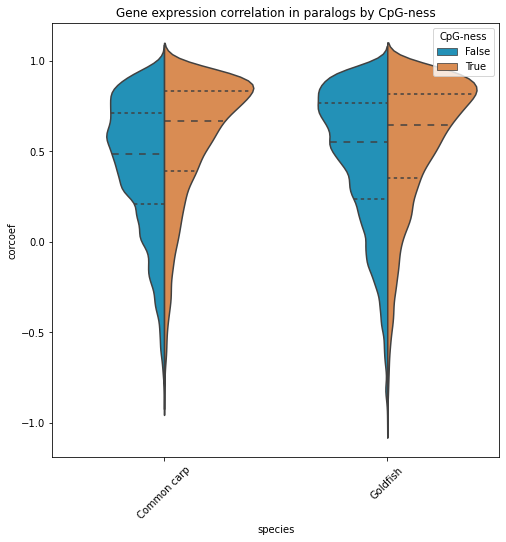

In [78]:
from seaborn import violinplot
import matplotlib.pyplot as pyplot
from pandas import concat
fig, ax = pyplot.subplots(figsize=(8,8))
pyplot.xticks(rotation=45)
data=concat([cc_expr.assign(corcoef=[x[0] if x != None else None for x in cc_expr['expr_corr']]).assign(species="Common carp"),
             ca_expr.assign(corcoef=[x[0] if x != None else None for x in ca_expr['expr_corr']]).assign(species="Goldfish")])
violinplot(ax=ax, x="species", y="corcoef", hue="CpG-ness", data=data, palette=['#0b9dcf','#ef893d'], split=True, inner="quartiles")

plt.title('Gene expression correlation in paralogs by CpG-ness')
plt.savefig('cc-ca-gene-expression-corr-paralog-by-cgi.pdf', dpi=600)
plt.show()

In [165]:
from itertools import *
uni=read_csv('/data/db/import/uniprot_human_2.csv', delimiter='\t')
prot_to_gene = dict((x[0], x[1]) for x in uni.dropna().iloc)
cmps=read_csv('/data/db/import/coreComplexes.txt', delimiter='\t')

cmpxs=[(r[0], set([prot_to_gene[p] for p in r[1].split(';') if p in prot_to_gene])) for r in cmps[['ComplexID', 'subunits(UniProt IDs)', 'Organism']].iloc if r[2] == 'Human']
{g : set(c[1] for c in c) for g, c in groupby(sorted(list(chain(*[[(x, c[0]) for x in c[1]] for c in cmpxs if len(c[1]) > 1])), key=lambda x: x[0]), lambda x: x[0])}
gene_to_complex={g : ';'.join((str(x) for x in set(c[1] for c in c))) for g, c in groupby(sorted(list(chain(*[[(x, c[0]) for x in c[1]] for c in cmpxs if len(c[1]) > 1])), key=lambda x: x[0]), lambda x: x[0])}


In [171]:
print('CGI-less genes that one partner is lost - %d in total, %d of these in CORUM\nCGI-less genes that both partners are retained - %d in total, %d of these are in CORUM'%
      (sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+(y[1] or y[2])) in cpg_less for y in x[1]) for x in segsols),
      sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+(y[1] or y[2])) in cpg_less and (y[1] or y[2]) in gene_to_complex for y in x[1]) for x in segsols),
      sum(sum((('gene:'+y[1]) in cpg_less) + (('gene:'+y[2]) in cpg_less) if y[0] != None and y[1] != None and y[2] != None else 0 for y in x[1]) for x in segsols),
      sum(sum((('gene:'+y[1]) in cpg_less) + (('gene:'+y[2]) in cpg_less) if y[0] != None and y[1] != None and y[2] != None and (y[1] in gene_to_complex or y[2] in gene_to_complex) else 0 for y in x[1]) for x in segsols)))
print('CGI-full genes that one partner is lost - %d in total, %d of these in CORUM\nCGI-full genes that both partners are retained - %d in total, %d of these are in CORUM'%
      (sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+(y[1] or y[2])) in cpg_full for y in x[1]) for x in segsols),
      sum(sum(y[0] != None and (y[1] != None and y[2] == None or y[2] != None and y[1] == None) and ('gene:'+(y[1] or y[2])) in cpg_full and (y[1] or y[2]) in gene_to_complex for y in x[1]) for x in segsols),
      sum(sum((('gene:'+y[1]) in cpg_full) + (('gene:'+y[2]) in cpg_full) if y[0] != None and y[1] != None and y[2] != None else 0 for y in x[1]) for x in segsols),
      sum(sum((('gene:'+y[1]) in cpg_full) + (('gene:'+y[2]) in cpg_full) if y[0] != None and y[1] != None and y[2] != None and (y[1] in gene_to_complex or y[2] in gene_to_complex) else 0 for y in x[1]) for x in segsols)))

CGI-less genes that one partner is lost - 790 in total, 83 of these in CORUM
CGI-less genes that both partners are retained - 442 in total, 14 of these are in CORUM
CGI-full genes that one partner is lost - 462 in total, 122 of these in CORUM
CGI-full genes that both partners are retained - 40 in total, 2 of these are in CORUM
